### Import the libraries and the data

In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, auc, roc_auc_score, plot_confusion_matrix, SCORERS, plot_roc_curve, classification_report, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_selector as selector

scoring = {'f1': make_scorer(f1_score),
           'roc_auc': make_scorer(roc_auc_score)}

np.random.seed(0)

In [2]:
train_df = pd.read_csv("../data/01_raw/attrition_train.csv")
test_df = pd.read_csv("../data/01_raw/attrition_test.csv")

In [3]:
(train_df.Over18 != 'Y').sum()

0

In [4]:
(test_df.Over18 != 'Y').sum()

0

In [5]:
(train_df.EmployeeCount != 1).sum()

0

In [6]:
(test_df.EmployeeCount != 1).sum()

0

In [7]:
(train_df.StandardHours != 80).sum()

0

In [8]:
(test_df.StandardHours != 80).sum()

0

In [9]:
train_df.drop(columns=['Over18', 'EmployeeCount', 'EmployeeNumber', 'StandardHours'], inplace=True)
test_df.drop(columns=['Over18', 'EmployeeCount', 'EmployeeNumber', 'StandardHours', 'index1'], inplace=True)

### Get info about column names, missing values and Dtype

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1100 non-null   int64 
 1   Attrition                 1100 non-null   object
 2   BusinessTravel            1100 non-null   object
 3   DailyRate                 1100 non-null   int64 
 4   Department                1100 non-null   object
 5   DistanceFromHome          1100 non-null   int64 
 6   Education                 1100 non-null   int64 
 7   EducationField            1100 non-null   object
 8   EnvironmentSatisfaction   1100 non-null   int64 
 9   Gender                    1100 non-null   object
 10  HourlyRate                1100 non-null   int64 
 11  JobInvolvement            1100 non-null   int64 
 12  JobLevel                  1100 non-null   int64 
 13  JobRole                   1100 non-null   object
 14  JobSatisfaction         

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       370 non-null    int64 
 1   BusinessTravel            370 non-null    object
 2   DailyRate                 370 non-null    int64 
 3   Department                370 non-null    object
 4   DistanceFromHome          370 non-null    int64 
 5   Education                 370 non-null    int64 
 6   EducationField            370 non-null    object
 7   EnvironmentSatisfaction   370 non-null    int64 
 8   Gender                    370 non-null    object
 9   HourlyRate                370 non-null    int64 
 10  JobInvolvement            370 non-null    int64 
 11  JobLevel                  370 non-null    int64 
 12  JobRole                   370 non-null    object
 13  JobSatisfaction           370 non-null    int64 
 14  MaritalStatus             

### Create X and y dataframes, split them into train and test, get the list of categorical and numeric features.

In [12]:
y = train_df.Attrition
X = train_df.drop(['Attrition'], axis=1)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

categorical_features = [cname for cname in X_train.columns if 
                    X_train[cname].dtype == "object"]
numeric_features = [cname for cname in X_train.columns if 
                    X_train[cname].dtype == "int64"]

In [107]:
categorical_features

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [108]:
numeric_features

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

### Preprocess the training data, create the classifier model and fit it with the data.

In [285]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(random_state=0))])



clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                      

### Get an extended list of numeric features, with the One Hot encoded categorical features.

In [221]:
onehot_columns = list(clf.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names(input_features=categorical_features))
numeric_features_list = list(numeric_features)
numeric_features_list.extend(onehot_columns)

In [222]:
numeric_features_list

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'BusinessTravel_Non-Travel',
 'BusinessTravel_Travel_Frequently',
 'BusinessTravel_Travel_Rarely',
 'Department_Human Resources',
 'Department_Research & Development',
 'Department_Sales',
 'EducationField_Human Resources',
 'EducationField_Life Sciences',
 'EducationField_Marketing',
 'EducationField_Medical',
 'EducationField_Other',
 'EducationField_Technical Degree',
 'Gender_Female',
 'Gender_Male',
 'JobRole_Healthcare Representative',
 'JobRole_Human Resources',
 'JobRole_Laboratory Technician',
 'JobRole_Manager',
 'Job

### Associate the features list to their coefficient in a dataframe, sorted in descending order.

In [283]:
coefs = best_clf.named_steps['classifier'].coef_
features_coef = pd.DataFrame(numeric_features_list)
features_coef['coef'] = pd.Series(coefs[0])
features_coef.rename(columns={0: "features"}, inplace=True)
features_coef.sort_values(by='coef', ascending=False)

,features,coef
45,JobRole_Sales Representative,1.164649
29,EducationField_Human Resources,1.136431
24,BusinessTravel_Travel_Frequently,0.989427
34,EducationField_Technical Degree,0.808924
19,YearsAtCompany,0.782316
21,YearsSinceLastPromotion,0.657373
48,MaritalStatus_Single,0.503620
50,OverTime_Yes,0.395513
11,NumCompaniesWorked,0.331009
2,DistanceFromHome,0.286214


In [224]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [225]:
f1_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
roc_auc_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc')
precision_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')


print("Average F1 scores: %.3f\n" % f1_scores.mean())
print("Average roc auc scores: %.3f\n" % roc_auc_scores.mean())
print("Average Precision scores: %.3f\n" % precision_scores.mean())
print("Average Recall scores: %.3f\n" % recall_scores.mean())


/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinea

### Recherche des paramètres du modèle de classification par une validation croisée

In [271]:
param_grid = {
    'classifier__C': [1, 3, 10, 30, 100],
    'classifier__dual': [True, False],
    'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'classifier__l1_ratio' : [0.3, 0.5, 0.7]

}


grid_search = GridSearchCV(clf, param_grid, scoring=scoring, refit='roc_auc', cv=5)

grid_search.fit(X_train, y_train)

e "/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    raise ValueError("Only 'saga' solver supports elasticnet penalty,"
ValueError: Only 'saga' solver supports elasticnet penalty, got solver=liblinear.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit fai

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'DailyRate',
                                                                          'DistanceFromHome',
                                                                          'Education',
                                                                          'EnvironmentSatisfaction',
                                                                          'HourlyRate',
                                                                          'JobInvolvement',
    

In [272]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                      

In [273]:
grid_search.best_score_

0.7623418985487952

In [274]:
grid_search.best_params_

{'classifier__C': 1,
 'classifier__dual': False,
 'classifier__l1_ratio': 0.3,
 'classifier__penalty': 'l1',
 'classifier__solver': 'liblinear'}

In [275]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'classifier', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__scaler', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__categories', 'preprocessor__cat__drop', 'preprocessor__cat__dtype', 'preprocessor__cat__handle_unknown', 'preprocessor__cat__sparse', 'classifier__C', 'classifier__class_weight', 'classifier__dual', 'classifier__fit_intercept', 'classifier__intercept_scaling', 'classifier__l1_ratio', 'classifier__max_iter', 'classifier__multi_class', 'classifier__n_jobs', 'classifier__penalty', 'classifier__random_state', 'classifier__solver', 'classifier__tol', 'classifie

In [276]:
best_clf = grid_search.best_estimator_

In [229]:
y_pred_proba = clf.predict_proba(X_test)
y_pred_proba[1][1]
attrition_score = []
for i in range(len(X_test)):
    attrition_score.append(y_pred_proba[i][1])


In [295]:
y_pred = best_clf.predict(X_test)

In [287]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

In [288]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [289]:
confusion_matrix(y_test, y_pred)

array([[176,   8],
       [ 21,  15]])

In [290]:
print("Sur les 220 salariés du jeu de données test :\n")
print("Le nombre de personnes qui ont quitté l'entreprise est : {}".format(fn + tp))
print("Le nombre de personnes dont on a prédit qu'il allaient quitter l'entreprise: {}".format(tp + fp))
print("Le nombre de personnes qui sont restées dans l'entreprise: {}".format(tn + fp))
print("Le nombre de cas total où on s'est trompé: {}".format(fn + fp))
print("Le nombre de cas où on s'est trompé sur des personnes qui avaient l'intention de partir: {}".format(fn))
print("Le nombre de cas où on s'est trompé sur des personnes qui voulaient rester: {}".format(fp))


Sur les 220 salariés du jeu de données test :

Le nombre de personnes qui ont quitté l'entreprise est : 36
Le nombre de personnes dont on a prédit qu'il allaient quitter l'entreprise: 23
Le nombre de personnes qui sont restées dans l'entreprise: 184
Le nombre de cas total où on s'est trompé: 29
Le nombre de cas où on s'est trompé sur des personnes qui avaient l'intention de partir: 21
Le nombre de cas où on s'est trompé sur des personnes qui voulaient rester: 8


### Calcul des métriques

In [291]:
print("Métriques calculées par sklearn.metrics\n")
print("Précision : %.3f" % precision_score(y_test, y_pred))
print("Accuracy : %.3f" % accuracy_score(y_test, y_pred))
print("Rappel (ou sensibilité) : %.3f" % recall_score(y_test, y_pred))
print("F-measure : %.3f\n" % f1_score(y_test, y_pred))

print("Métriques recalculées\n")
print("Précision : {}".format(tp /(tp + fp)))
print("Accuracy : {}".format((tp + tn) /(tp + fp + tn + fn)))
print("Rappel (ou sensibilité) : {}".format(tp /(tp + fn)))
print("Spécificité : {}".format(tn /(fp + tn)))
print("F-measure : {}\n".format(2*tp /(2*tp + fp + fn)))


Métriques calculées par sklearn.metrics

Précision : 0.652
Accuracy : 0.868
Rappel (ou sensibilité) : 0.417
F-measure : 0.508

Métriques recalculées

Précision : 0.6521739130434783
Accuracy : 0.8681818181818182
Rappel (ou sensibilité) : 0.4166666666666667
Spécificité : 0.9565217391304348
F-measure : 0.5084745762711864



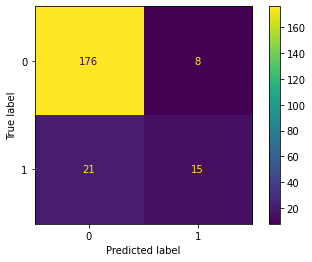

In [292]:
plot_confusion_matrix(clf, X_test, y_test)  
plt.show() 

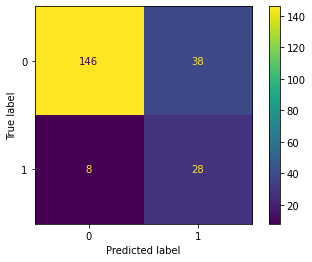

In [277]:
plot_confusion_matrix(best_clf, X_test, y_test)  
plt.show()

On veut améliorer le rappel (recall) ou sensibilité et la précision.


Le rappel est intuitivement la capacité du classificateur à trouver tous les échantillons positifs.
Un mauvais rappel signifie dans notre cas que nous avons sélectionné peu d'éléments pertinents et donc manqué de proposer le programme d'accompagnement à des personnes qui souhaitaient quitter l'entreprise.
Or, c'est précisément ce que nous ne voulons pas pour éviter le turn-over.

La précision est intuitivement la capacité du classificateur à ne pas étiqueter comme positif un échantillon qui est négatif.
Dans notre cas, une mauvaise précision nous fera inscrire au programme d'accompagnement des personnes qui ne souhaitaient pas quitter l'entreprise, ce qui occasionera un coût non nécessaire, en plus de prendre des places qui auraient été plus utiles si elles avaient étaient attribuées aux personnes susceptibles de partir.


Le score F1 peut être interprété comme une moyenne pondérée de la précision et du rappel, où un score F1 atteint sa meilleure valeur à 1 et son pire score à 0. La contribution relative de la précision et du rappel au score F1 est égale.


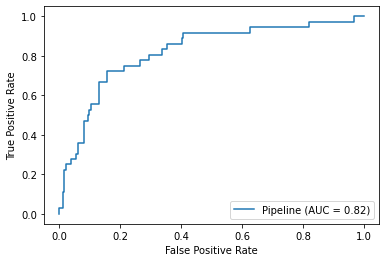

In [237]:
plot_roc_curve(clf, X_test, y_test)
plt.show()    

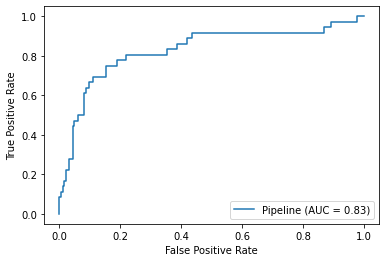

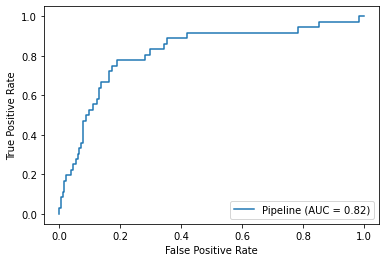

In [294]:
plot_roc_curve(clf, X_test, y_test)
plot_roc_curve(best_clf, X_test, y_test)
plt.show()  

In [296]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86       184
           1       0.42      0.78      0.55        36

    accuracy                           0.79       220
   macro avg       0.69      0.79      0.71       220
weighted avg       0.86      0.79      0.81       220



### Prédiction du taux d'attrition pour les employés de l'entreprise (fichier attrition_test.csv)

In [239]:
clf.fit(X, y)


/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'DailyRate',
                                                   'DistanceFromHome',
                                                   'Education',
                                                   'EnvironmentSatisfaction',
                                                   'HourlyRate',
                                                   'JobInvolvement', 'JobLevel',
                                                   'JobSatisfaction',
                                                   'MonthlyIncome',
                                                   'MonthlyRate',
                                                   'NumCompaniesWorked',
                                      

In [249]:
f1_scores = cross_val_score(clf, X, y, cv=5, scoring='f1')
roc_auc_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
precision_scores = cross_val_score(clf, X, y, cv=5, scoring='precision')
recall_scores = cross_val_score(clf, X, y, cv=5, scoring='recall')


print("Average F1 scores: %.3f\n" % f1_scores.mean())
print("Average roc auc scores: %.3f\n" % roc_auc_scores.mean())
print("Average Precision scores: %.3f\n" % precision_scores.mean())
print("Average Recall scores: %.3f\n" % recall_scores.mean())


/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/apprenant/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinea

In [241]:
#attrition_score_pred = clf.predict_proba(test_df)
#attrition_score_pred

In [242]:
#attrition_pred = clf.predict(test_df)
#attrition_pred